In [3033]:
import rebound 

import sympy as sp
from matplotlib import pyplot as plt
from matplotlib import pyplot

import numpy as np

from sympy import init_printing
init_printing()

%matplotlib inline
from sympy import *

import math

In [3034]:
# plot style and colour
plt.style.use('seaborn')
plt.rcParams['axes.facecolor']='whitesmoke'

# plot border
plt.rcParams["axes.edgecolor"] = '0'
plt.rcParams["axes.linewidth"]  = 0.7

# Predicting an Astrometric signal

## Variables set 

In [3035]:
timescale = 4.2


# planet parameters 
planet_inc = 0
m_planet = 0.0143188

# star parameters 
m_star  = 1                                                # M_sun
#z_star  = 50*206265                                        # AU
v_star  = 4.74*(50*0.001)*(50)* (1/1.496e+8) * (3.154e+7)  # AU/year
#vz_star = 0.1*v_star                                       # AU/year

z_star = 25*206265   
vz_star = 0.65*v_star   

## Simulations

In [3036]:
sim_wp = rebound.Simulation()                                                               # create a simulation named sim_wp 

sim_wp.units=["msun","AU","year"]                                                           # setting units of sim_wpm

sim_wp.add(m=1)                                                                             # add the Sun as the central object 

sim_wp.add(m=3.0027e-6, a=1, e=0)                                                           # add Earth in a 1 AU circular orbit 

sim_wp.add(x = 1.031e7, vy=v_star, m = m_star, z = z_star, vz=vz_star)                      # add a star 50 pc away with calculated velocity and set parameters

sim_wp.add(m = m_planet, a = 0.6, e = 0.2, primary = sim_wp.particles[2], inc=planet_inc)  # add planet from figure 3.1 caption and have it orbit the star 

In [3037]:
com_particle = sim_wp.calculate_com(first=2,last=4)

In [3038]:
sim = rebound.Simulation()                          # create a simulation named sim 

sim.units=["msun","AU","year"]                      # setting units of sim 

sim.add(m=1)                                        # add the Sun as the central object 

sim.add(m=3.0027e-6, a=1, e=0)                      # add Earth in a 1 AU circular orbit 

sim.add(com_particle)                               # add a particle equivaent to the star-planet barycentre

## Arrays to hold data 

In [3039]:
m = 200
times = np.linspace(0,timescale,num=m)

In [3040]:
# positions 
pos_sun   , pos_sun_wp    = np.zeros((m,3)) , np.zeros((m,3))          # sun
pos_earth , pos_earth_wp  = np.zeros((m,3)) , np.zeros((m,3))          # earth 
pos_star  , pos_star_wp   = np.zeros((m,3)) , np.zeros((m,3))          # star 
pos_planet_wp             = np.zeros((m,3))                            # planet 

# center of masses  
sun_earth_com , sun_earth_com_wp  = np.zeros((m,3)) , np.zeros((m,3))   # sun and earth center of mass
all_com                        = np.zeros((m,3))                     # center of mass of all objects - with planet 

# r_star - r_earth vector
r_SE, r_SE_wp  = np.zeros((m,3)), np.zeros((m,3))                      # for ______

# length of vectors in xy-plane  
r_SE_xy, r_SE_xy_wp = np.zeros((m,1)), np.zeros((m,1))                  # r_star - r_earth
r_all_com_xy = np.zeros((m,1))                                          # for ______

# right ascension and declination
alpha , delta  = np.empty((m,1)) , np.empty((m,1))                                # for r_star - r_earth vector without planet 
alpha_wp , delta_wp  = np.empty((m,1)) , np.empty((m,1))                          # for r_star - r_earth vector with planet 
alpha_all_com, delta_all_com = np.zeros((m,1)), np.zeros((m,1))                   # for ______

## Filling arrays with data using a for loop

In [3041]:
for i,t in enumerate(times):
    sim.integrate(t)
    sim_wp.integrate(t)
    
    # positions of sun, earth and star
    pos_sun[i]   , pos_sun_wp[i]     = sim.particles[0].xyz,   sim_wp.particles[0].xyz
    pos_earth[i] , pos_earth_wp[i]   = sim.particles[1].xyz,   sim_wp.particles[1].xyz
    pos_star[i]  , pos_star_wp[i]    = sim.particles[2].xyz,   sim_wp.particles[2].xyz
    pos_planet_wp[i]                 =                         sim_wp.particles[3].xyz
    
    # centre of mass of sun and earth 
    com_sun_earth, com_sun_earth_wp       = sim.calculate_com(last=2), sim_wp.calculate_com(last=2)
    sun_earth_com[i], sun_earth_com_wp[i] = com_sun_earth.xyz, com_sun_earth_wp.xyz
    
    # center of mass of all objects
    com_all =  sim_wp.calculate_com()
    all_com[i] = com_all.xyz
    
    # creating vectors wrt earth 
    r_SE[i], r_SE_wp[i] = pos_star[i] - pos_earth[i], pos_star_wp[i] - pos_earth_wp[i] # r_star - r_earth

    #length of vectors wrt in the x-y-plane 
    r_SE_xy[i] , r_SE_xy_wp[i]  = np.sqrt(r_SE[i,0]**2 + r_SE[i,1]**2)      , np.sqrt(r_SE_wp[i,0]**2 + r_SE_wp[i,1]**2) # r_star
    r_all_com_xy[i]             = np.sqrt(all_com[i,0]**2+all_com[i,1]**2)  
    
    # calculating RA and Dec in mas
    alpha[i] , alpha_wp[i] = np.arctan((r_SE[i,1]/r_SE[i,0])) *206264806.24709466 , np.arctan((r_SE_wp[i,1]/r_SE_wp[i,0]))*206264806.24709466
    delta[i] , delta_wp[i] = np.arctan((r_SE[i,2]/r_SE_xy[i]))*206264806.24709466 , np.arctan((r_SE_wp[i,2]/r_SE_xy_wp[i]))*206264806.24709466
    
    alpha_all_com[i] = np.arctan((all_com[i,1]/all_com[i,0]))  * 206264806.24709466 
    delta_all_com[i] = np.arctan((all_com[i,2]/r_all_com_xy[i,0])) * 206264806.24709466 

## Plots

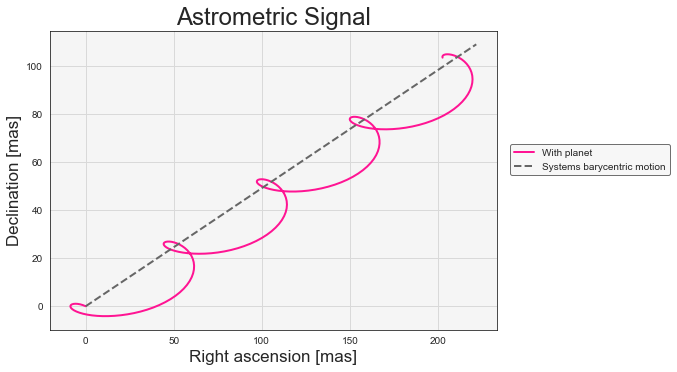

In [3042]:
# plotting data 
#plt.plot(alpha, delta-delta[0], color='limegreen',linewidth=2, markersize=12, label='Without planet')
plt.plot(alpha_wp, delta_wp-delta_wp[0], color='deeppink',linewidth=2, markersize=12, label='With planet')
plt.plot(alpha_all_com, delta_all_com-delta_all_com[0], color='0.4',linewidth=2, linestyle='dashed', markersize=12, label='Systems barycentric motion')


# set titles 
plt.title('Astrometric Signal',fontsize = 24)             
plt.xlabel('Right ascension [mas]',fontsize = 17)                     
plt.ylabel('Declination [mas]',fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.4, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### The pink data is the signal from the planet and star and the green is just the star. So when we subtract the without planet signal from the with planet signal (planet + star - star), we are left with the signal from just the planet. This data is an elliptical orbit, representing the planets orbit aorund the planet-star barycentre.  

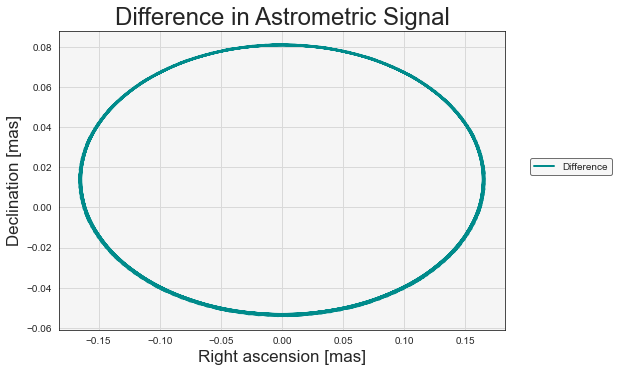

In [3043]:
# plotting data 
plt.plot(alpha-alpha_wp, delta-delta_wp, color='darkcyan',linewidth=2, markersize=12, label='Difference')

# set titles 
plt.title('Difference in Astrometric Signal',fontsize = 24)             
plt.xlabel('Right ascension [mas]',fontsize = 17)                     
plt.ylabel('Declination [mas]',fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.25, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

# Reproducing astrometric signal using equations 3.22 and 3.23

In [3056]:
M                 = np.zeros((m,1))
E                 = np.zeros((m,1))
X                 = np.zeros((m,1))
Y                 = np.zeros((m,1))
PI                = np.zeros((m,2))
sum_elements      = np.zeros((m,2))
three22           = np.zeros((m,1))
three23           = np.zeros((m,1))
barycentic_motion = np.zeros((m,2))
parallax_motion   = np.zeros((m,2))

In [3057]:
timescale1 = 3.5                                             # timescale                                   [years]
tau        = 0                                               # time of pericentre passage                  [years]
t0         = 0                                               # wrt Julian date                             [years]

a_AU   = 0.6                                                 # semi-major axis                             [AU]
e      = 0.2                                                 # ellipticity of the orbit                    [unitless]
omega  = 0                                                   # argument of perihelion                      [rad] 
OMEGA  = 0                                                   # longitude of the ascending node             [rad]
i      = planet_inc                                          # orbital inclination                         [rad]

alpha1 = 0.001                                               # randomly chosen                             [rad]
delta1 = -100                                                # randomly chosen                             [rad]

change_RA_0  = 0.120*4.84814e-6*1000                         # change in RA at time t_0                    [as]
change_DEC_0 = 0.160*4.84814e-6*1000                         # change in DEC at time t_0                   [as]


parallax = 1/50                                              # parallax of the system                      [as]
r = pos_earth_wp

P = a_AU**(3/2)                                              # period of the system                        [years]
a_as = ((parallax*m_planet)**3*(P/(m_star+m_planet))**2)**(1/3) # semi-major axis                          [as]

proper_motion = 0.05                                               
theta         = np.arctan(120/160)                           # angle between prop motion.                  [rad]
prop_RA       = proper_motion*np.sin(theta)/np.cos(delta1)   # proper motion in RA direction               [as/year]
prop_DEC      = proper_motion*np.cos(theta)                  # proper motion in DEC direction              [as/year]

In [3060]:
A = a_as * (  np.cos(omega) * np.cos(OMEGA) - np.sin(omega) * np.sin(OMEGA) * np.cos(i))
B = a_as * (  np.cos(omega) * np.sin(OMEGA) + np.sin(omega) * np.cos(OMEGA) * np.cos(i))
F = a_as * (- np.sin(omega) * np.cos(OMEGA) - np.cos(omega) * np.sin(OMEGA) * np.cos(i))
G = a_as * (- np.sin(omega) * np.sin(OMEGA) + np.cos(omega) * np.cos(OMEGA) * np.cos(i))

#### Calculate:
- mean anomaly $M$ using the equation: $M=\frac{2\pi}{T}(t-\tau)=\frac{2\pi}{a^{3/2}}(t-\tau)$ (Exoplanet handbook 2.9) 
- Eccentric anomaly $E$ using rebound
- elliptical rectangular coordinates  using the equations $X=\cos(E(t))-e$ and $Y=\sqrt{(1-e^2)}\sin(E(t))$ (Exoplanet handbook equations 3.21)
- Orthogonal components of the displacements due to parallax using equation 3.24 from the Exoplanet handbook: $\Pi_{\alpha,t}=r_x(t)\sin\alpha-r_y(t)\cos\alpha$ and $\Pi_{\beta,t}=\left[r_x(t)\cos\alpha+r_y\sin\alpha\right]\sin\delta-r_z(t)\cos\delta$
- the sum part of equations 3.22 and 3.23 from the Exoplanet handbook: $BX_t+GY_t$ and $AX_t+FY_t$

In [3061]:
times1 = np.linspace(0,timescale1,num=m)

In [3062]:
k = 0
for k, t in enumerate(times1):
    M[k] = (2*np.pi/a_AU**(3/2))*(t - tau)
    E[k] = rebound.M_to_E(e,M[k]) 
    X[k] = np.cos(E[k]) - e
    Y[k] = np.sqrt(1-e**2) * np.sin(E[k])
    PI[k,0] =  r[k,0] * np.sin(alpha1) - r[k,1] * np.cos(alpha1)
    PI[k,1] = (r[k,0] * np.cos(alpha1) + r[k,1] * np.sin(alpha1)) * np.sin(delta1) - r[k,2] * np.cos(delta1)
    sum_elements[k,0] = B*X[k] + G*Y[k]
    sum_elements[k,1] = A*X[k] + F*Y[k]

In [3063]:
sum_alpha = np.sum(sum_elements[:,0])
sum_delta = np.sum(sum_elements[:,1])

### The final equations we are calculating are:
- 3.22: $\Delta\alpha(t)\cos\delta=\left[BX_t+GY_t\right]+ \Delta\alpha_0\cos\delta+\varpi\Pi_{\alpha,t}+\mu_\alpha(t-t_0)$
- 3.23: $\Delta\delta(t)=\left[AX_t+F_t\right]+\Delta\delta_0+\varpi\Pi_{\alpha,t}+\mu_\delta(t-t_0)$

In [3064]:
for d,t in enumerate(times1):
    three22[d] = (sum_alpha + change_RA_0 * np.cos(delta1)    + parallax * PI[d,0] + prop_RA  * (t - t0))
    three23[d] = (sum_delta + change_DEC_0                    + parallax * PI[d,1] + prop_DEC * (t - t0))
    
    barycentic_motion[d,0] = (three22[d] - parallax * PI[d,0])*1000                                       
    barycentic_motion[d,1] = (three23[d] - parallax * PI[d,1])*1000                                           
    
    parallax_motion[d,0] = (three22[d] - sum_alpha - change_RA_0  * np.cos(delta1))*1000                     
    parallax_motion[d,1] = (three23[d] - sum_delta - change_DEC_0)*1000                                      

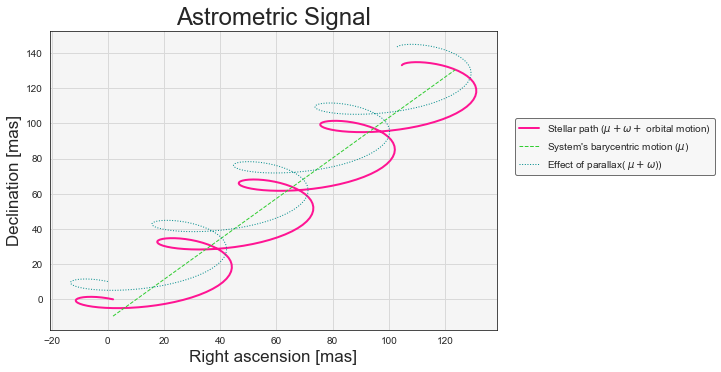

In [3065]:
# plotting data multiplied by 1000 to get it into mas
plt.plot(three22*1000          , (three23-three23[0])*1000          , color='deeppink' , linewidth=2, markersize=12,                     label = 'Stellar path ($\mu + \omega +$ orbital motion)')
plt.plot(barycentic_motion[:,0], barycentic_motion[:,1] , color='limegreen', linewidth=1, markersize=12, linestyle='dashed', label = 'System\'s barycentric motion ($\mu$)')
plt.plot(parallax_motion[:,0]  , parallax_motion[:,1]    , color='darkcyan' , linewidth=1, markersize=12, linestyle='dotted', label = 'Effect of parallax( $\mu + \omega $))')

# set titles 
plt.title('Astrometric Signal'    , fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

# Comparing methods

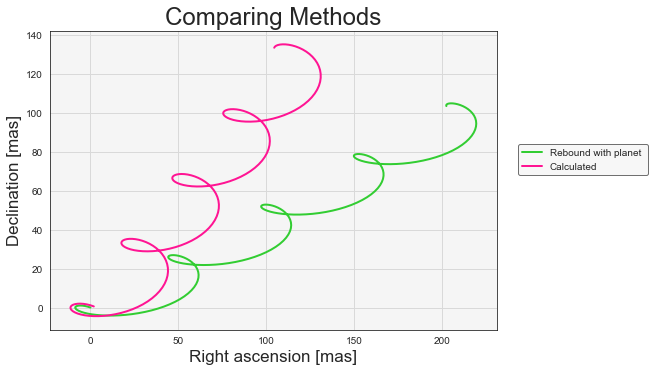

In [3066]:
# plotting data 
plt.plot(alpha_wp, delta_wp-delta_wp[0], color='limegreen',linewidth=2, markersize=12, label='Rebound with planet ')
plt.plot(three22*1000, three23*1000, color='deeppink',linewidth=2, markersize=12, label='Calculated')

# set titles 
plt.title('Comparing Methods',fontsize = 24)             
plt.xlabel('Right ascension [mas]',fontsize = 17)                     
plt.ylabel('Declination [mas]',fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.35, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

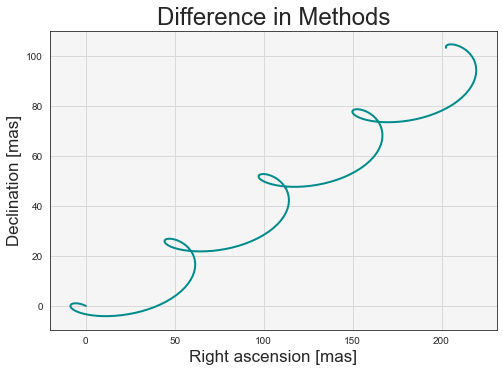

In [3067]:
# plotting data 
plt.plot((alpha_wp-three22), ((delta_wp-delta_wp[0])-three23), color='darkcyan',linewidth=2, markersize=12)

# set titles 
plt.title('Difference in Methods',fontsize = 24)             
plt.xlabel('Right ascension [mas]',fontsize = 17)                     
plt.ylabel('Declination [mas]',fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

In [ ]:
x = np.linspace(0,120,160)
y = 1.33333*x
#plt.plot(x, y, '-r', label='y=1.333x', color='black', linestyle='dashed')
#plt.scatter(29,11,label='2018.4', color='black')
#plt.scatter(60,82,label='2019.6', color='black')
#plt.scatter(80,120,label='2010.8', color='black')